# Lab 4
### Zespół
- Krzysztof Kordal
- Szymon Szewczyk
- Łukasz Szyszka

### Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, NonlinearConstraint

### Funkcje celu

In [4]:
def F1(u):
    x, y = u
    return x**2 + y**2

def F2(u):
    x, y = u
    return (x - 1)**2 + y**2

### Skalaryzacja przez funkcję liniową

In [5]:
def weighted_sum_method(F1, F2, bounds, x0, num_steps=20):
    lambda_values = np.linspace(0, 1, num_steps)
    results = []

    def scalarization_weighted_sum(u, lambdas):
        return lambdas[0] * F1(u) + lambdas[1] * F2(u)

    for l in lambda_values:
        lambdas = [l, 1 - l]
        res = minimize(scalarization_weighted_sum, x0, args=(lambdas,), bounds=bounds)
        if res.success:
            u_opt = res.x
            F_opt = [F1(u_opt), F2(u_opt)]
            results.append(F_opt)
        else:
            print(f"Optimization failed for lambdas: {lambdas}")
    return np.array(results)

### metoda eps-ograniczeń,

In [6]:
def epsilon_constraint_method(F1, F2, bounds, x0, num_steps=20):
    # Find the range of F2 over the domain
    x_vals = np.linspace(-1, 1, 50)
    y_vals = np.linspace(-1, 1, 50)
    X, Y = np.meshgrid(x_vals, y_vals)
    F2_vals = (X - 1)**2 + Y**2
    F2_min = F2_vals.min()
    F2_max = F2_vals.max()

    epsilon_values = np.linspace(F2_min, F2_max, num_steps)
    results = []

    for epsilon in epsilon_values:
        # Constraint: F2(u) <= epsilon
        constraint = NonlinearConstraint(F2, -np.inf, epsilon)
        res = minimize(F1, x0, bounds=bounds, constraints=[constraint])
        if res.success:
            u_opt = res.x
            F_opt = [F1(u_opt), F2(u_opt)]
            results.append(F_opt)
        else:
            print(f"Optimization failed for epsilon: {epsilon}")
    return np.array(results)

### skalaryzacja przez odległość od wybranego punktu dominującego x

In [7]:
def distance_based_method(F1, F2, bounds, x0, num_steps=20, p=2):
    # Compute the ideal point (not necessarily attainable)
    res_F1_min = minimize(F1, x0, bounds=bounds)
    F1_min = res_F1_min.fun

    res_F2_min = minimize(F2, x0, bounds=bounds)
    F2_min = res_F2_min.fun

    # Reference point (slightly better than the ideal to ensure dominance)
    delta = 0.5
    x_ref = np.array([F1_min - delta, F2_min - delta])

    lambdas_values = np.linspace(0.01, 0.99, num_steps)
    results = []

    def scalarization_distance(u, x_ref, lambdas, p):
        F_u = np.array([F1(u), F2(u)])
        diff = F_u - x_ref
        weighted_diff = lambdas * np.abs(diff)
        norm = np.linalg.norm(weighted_diff, ord=p)
        return norm

    for l in lambdas_values:
        lambdas = np.array([l, 1 - l])
        res = minimize(scalarization_distance, x0, args=(x_ref, lambdas, p), bounds=bounds)
        if res.success:
            u_opt = res.x
            F_opt = [F1(u_opt), F2(u_opt)]
            results.append(F_opt)
        else:
            print(f"Optimization failed for lambdas: {lambdas}")
    return np.array(results)

### Dalsza część

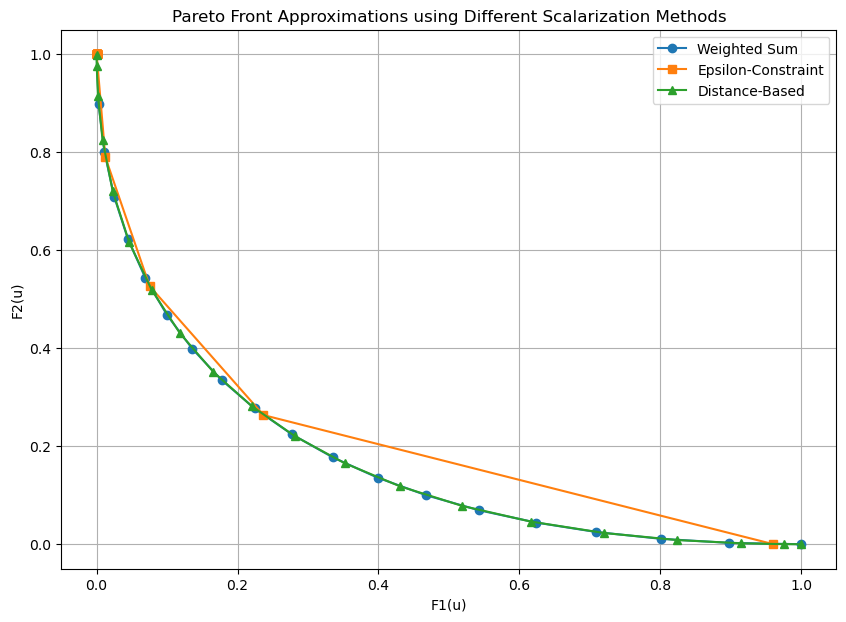

In [8]:
bounds = Bounds([-1, -1], [1, 1])  # U = [-1, 1] x [-1, 1]

# Initial guess for optimization
x0 = np.array([0.0, 0.0])

num_steps = 20

# Run Weighted Sum Method
results_weighted_sum = weighted_sum_method(F1, F2, bounds, x0, num_steps)

# Run Epsilon-Constraint Method
results_epsilon_constraint = epsilon_constraint_method(F1, F2, bounds, x0, num_steps)

# Run Distance-Based Scalarization Method
results_distance = distance_based_method(F1, F2, bounds, x0, num_steps, p=2)

# Plotting the results
plt.figure(figsize=(10, 7))

# Plot results from Weighted Sum method
plt.plot(results_weighted_sum[:, 0], results_weighted_sum[:, 1], 'o-', label='Weighted Sum')

# Plot results from Epsilon-Constraint method
plt.plot(results_epsilon_constraint[:, 0], results_epsilon_constraint[:, 1], 's-', label='Epsilon-Constraint')

# Plot results from Distance-Based Scalarization method
plt.plot(results_distance[:, 0], results_distance[:, 1], '^-', label='Distance-Based')

plt.xlabel('F1(u)')
plt.ylabel('F2(u)')
plt.title('Pareto Front Approximations using Different Scalarization Methods')
plt.legend()
plt.grid(True)
plt.show()
